### IMPORTING LIBRARIES

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_curve, precision_recall_curve, auc

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    RocCurveDisplay,
    precision_recall_curve,
)

from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from scipy import sparse

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# For reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

print("Libraries imported successfully.")

Libraries imported successfully.


### DATASET PREPARATION

In [580]:
# Load the dataset
try:
    df = pd.read_csv('preprocessed_dataset/preprocessed_data.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    raise FileNotFoundError("CSV not found. Place it in 'preprocessed_dataset/' or adjust the path.")

Dataset loaded successfully.


#### Prepare Target

Churn value counts:
Churn
0    5174
1    1869
Name: count, dtype: int64


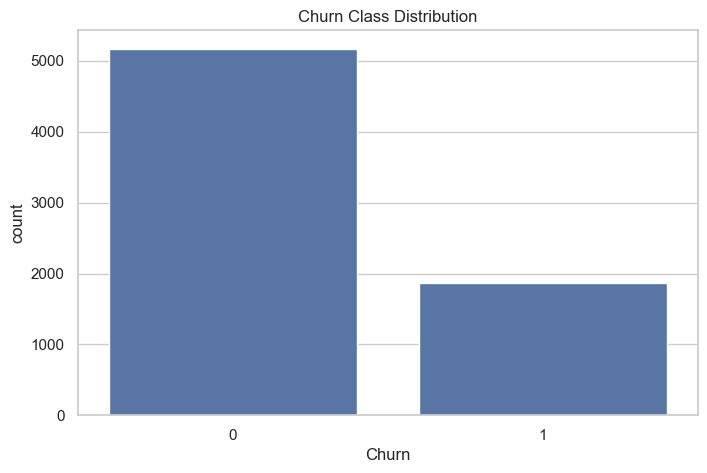

In [582]:
if "Churn" not in df.columns:
    raise ValueError(
        "Target column 'Churn' not found in the data. "
        "Make sure preprocessing keeps the target column named 'Churn'."
    )

# Target encoding: Yes/No -> 1/0 if needed
if not np.issubdtype(df["Churn"].dtype, np.number):
    print("Converting 'Churn' from Yes/No to 0/1 ...")
    df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})

# Ensure there are no NaNs in target
if df["Churn"].isna().any():
    raise ValueError("Target column 'Churn' contains NaN after encoding. Check preprocessing.")

df["Churn"] = df["Churn"].astype(int)

print("Churn value counts:")
print(df["Churn"].value_counts())

# Simple class balance plot
sns.countplot(x="Churn", data=df)
plt.title("Churn Class Distribution")
plt.show()

### TRAIN–TEST SPLIT

In [583]:
X = df.drop(columns=["Churn"])
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y,
)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

Train shape: (5634, 24)
Test shape : (1409, 24)


### PREPROCESSOR: ONEHOT + STANDARD SCALER

In [ ]:
preprocessor_nn = create_preprocessor(num_cols, cat_cols)

# Fit on training data only
X_train_proc = preprocessor_nn.fit_transform(X_train)
X_test_proc  = preprocessor_nn.transform(X_test)

# Convert to dense if sparse
if sparse.issparse(X_train_proc):
    X_train_proc = X_train_proc.toarray()
    X_test_proc  = X_test_proc.toarray()

print("Processed train shape:", X_train_proc.shape)
print("Processed test shape :", X_test_proc.shape)


Processed train shape: (5634, 49)
Processed test shape : (1409, 49)


#### Handle Class Imbalance with SMOTE (for NN)

In [585]:
smote = SMOTE(random_state=RANDOM_STATE)
X_train_sm, y_train_sm = smote.fit_resample(X_train_proc, y_train)

print("After SMOTE, train shape:", X_train_sm.shape)
print("After SMOTE, class distribution:")
print(pd.Series(y_train_sm).value_counts())

After SMOTE, train shape: (8278, 49)
After SMOTE, class distribution:
Churn
0    4139
1    4139
Name: count, dtype: int64


#### Helper Function: Evaluation & Plotting

In [586]:
def evaluate_classifier(y_true, y_pred, y_proba=None, model_name="Model"):
    """
    Print metrics + classification report and plot:
      - Confusion matrix
      - ROC curve (if probabilities are provided)
    in a single 1x2 subplot figure.
    Returns a dict with metrics.
    """
    # Basic metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    if y_proba is not None:
        roc_auc = roc_auc_score(y_true, y_proba)
    else:
        roc_auc = None

    print(f"\n=== {model_name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    if roc_auc is not None:
        print(f"ROC AUC  : {roc_auc:.4f}")

    print("\nClassification report:")
    print(classification_report(y_true, y_pred, digits=4))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if y_proba is not None:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    else:
        fig, axes = plt.subplots(1, 1, figsize=(6, 5))
        axes = [axes]

    # Confusion matrix heatmap
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        ax=axes[0],
    )
    axes[0].set_title(f"{model_name} - Confusion Matrix")
    axes[0].set_xlabel("Predicted label")
    axes[0].set_ylabel("True label")
    axes[0].set_xticklabels(["Not churn", "Churn"])
    axes[0].set_yticklabels(["Not churn", "Churn"], rotation=0)

    # ROC curve
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        axes[1].plot(fpr, tpr, linewidth=2, label=f"AUC = {roc_auc:.3f}")
        axes[1].plot([0, 1], [0, 1], "k--", linewidth=1)
        axes[1].set_title(f"{model_name} - ROC Curve")
        axes[1].set_xlabel("False Positive Rate")
        axes[1].set_ylabel("True Positive Rate")
        axes[1].legend(loc="lower right")

    plt.tight_layout()
    plt.show()

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc_auc,
    }


### BASELINE DECISION TREE (no hyperparameter tuning)


=== Decision Tree (Baseline) ===
Accuracy : 0.7232
Precision: 0.4817
Recall   : 0.5642
F1-score : 0.5197
ROC AUC  : 0.6722

Classification report:
              precision    recall  f1-score   support

           0     0.8321    0.7807    0.8056      1035
           1     0.4817    0.5642    0.5197       374

    accuracy                         0.7232      1409
   macro avg     0.6569    0.6724    0.6626      1409
weighted avg     0.7391    0.7232    0.7297      1409



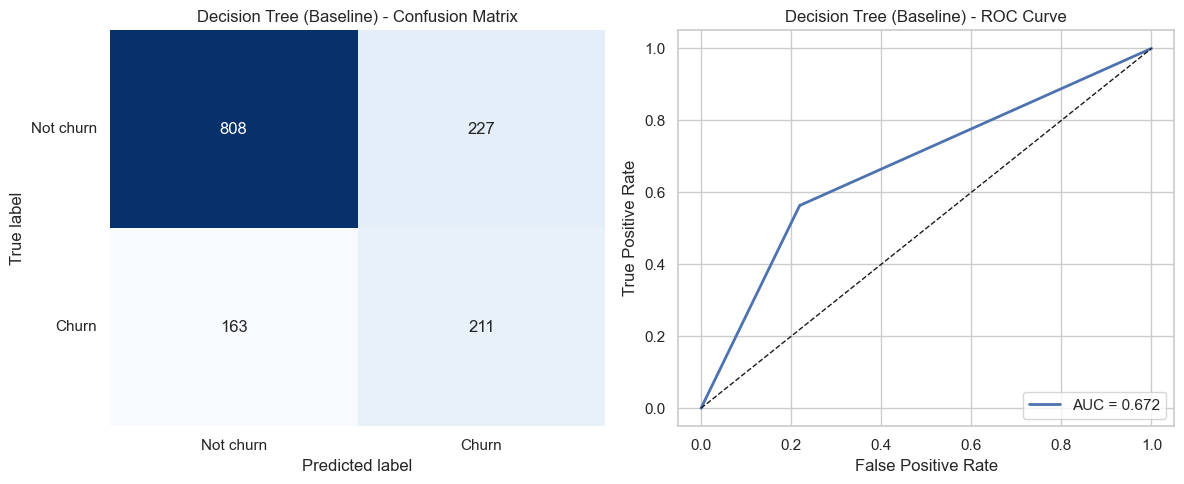

In [587]:
dt_baseline_pipe = ImbPipeline(
    steps=[
        ("preprocess", create_preprocessor(num_cols, cat_cols)),   # OneHot + Scaler
        ("smote", SMOTE(random_state=RANDOM_STATE)),               # SMOTE in pipeline
        ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE)),  # baseline DT
    ]
)

dt_baseline_pipe.fit(X_train, y_train)

y_pred_dt_base = dt_baseline_pipe.predict(X_test)
y_proba_dt_base = dt_baseline_pipe.predict_proba(X_test)[:, 1]

metrics_dt_base = evaluate_classifier(
    y_test,
    y_pred_dt_base,
    y_proba=y_proba_dt_base,
    model_name="Decision Tree (Baseline)",
)

### TUNED DECISION TREE (GridSearchCV)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best DT params: {'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2}
Best DT CV F1 : 0.6077443496935999

=== Decision Tree (Tuned) ===
Accuracy : 0.7459
Precision: 0.5156
Recall   : 0.7086
F1-score : 0.5968
ROC AUC  : 0.8154

Classification report:
              precision    recall  f1-score   support

           0     0.8782    0.7594    0.8145      1035
           1     0.5156    0.7086    0.5968       374

    accuracy                         0.7459      1409
   macro avg     0.6969    0.7340    0.7057      1409
weighted avg     0.7820    0.7459    0.7567      1409



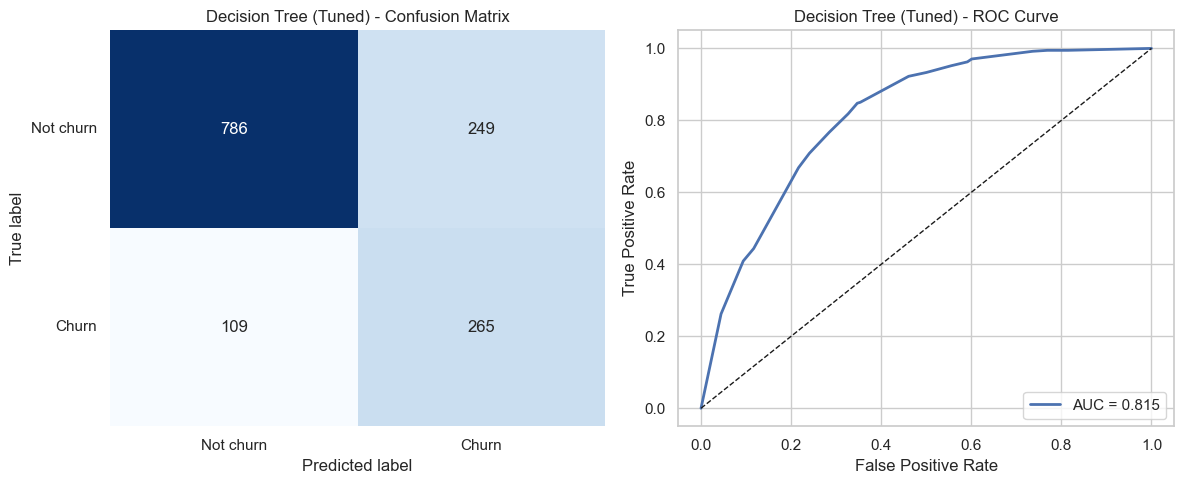

In [588]:
param_grid_dt = {
    "clf__max_depth": [None, 5, 10, 15],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__criterion": ["gini", "entropy"],
}

dt_tuned_pipe = ImbPipeline(
    steps=[
        ("preprocess", create_preprocessor(num_cols, cat_cols)),
        ("smote", SMOTE(random_state=RANDOM_STATE)),
        ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE)),
    ]
)

grid_dt = GridSearchCV(
    estimator=dt_tuned_pipe,
    param_grid=param_grid_dt,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=1,
)

grid_dt.fit(X_train, y_train)

print("Best DT params:", grid_dt.best_params_)
print("Best DT CV F1 :", grid_dt.best_score_)

best_dt_model = grid_dt.best_estimator_

y_pred_dt_tuned = best_dt_model.predict(X_test)
y_proba_dt_tuned = best_dt_model.predict_proba(X_test)[:, 1]

metrics_dt_tuned = evaluate_classifier(
    y_test,
    y_pred_dt_tuned,
    y_proba=y_proba_dt_tuned,
    model_name="Decision Tree (Tuned)",
)


### BASELINE NEURAL NETWORK (Keras)

Epoch 1/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7658 - loss: 0.4887 - val_accuracy: 0.7095 - val_loss: 0.6316 - learning_rate: 0.0010
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7839 - loss: 0.4572 - val_accuracy: 0.7150 - val_loss: 0.6124 - learning_rate: 0.0010
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7868 - loss: 0.4500 - val_accuracy: 0.7186 - val_loss: 0.5994 - learning_rate: 0.0010
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7887 - loss: 0.4450 - val_accuracy: 0.7216 - val_loss: 0.5910 - learning_rate: 0.0010
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7910 - loss: 0.4404 - val_accuracy: 0.7246 - val_loss: 0.5858 - learning_rate: 0.0010
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7915 - loss: 0.4360 - val_accuracy: 0.7283 - val_loss: 0.5811 - learning_rate: 0.0010
Epoch 7/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7960 - loss: 0.4315 - 

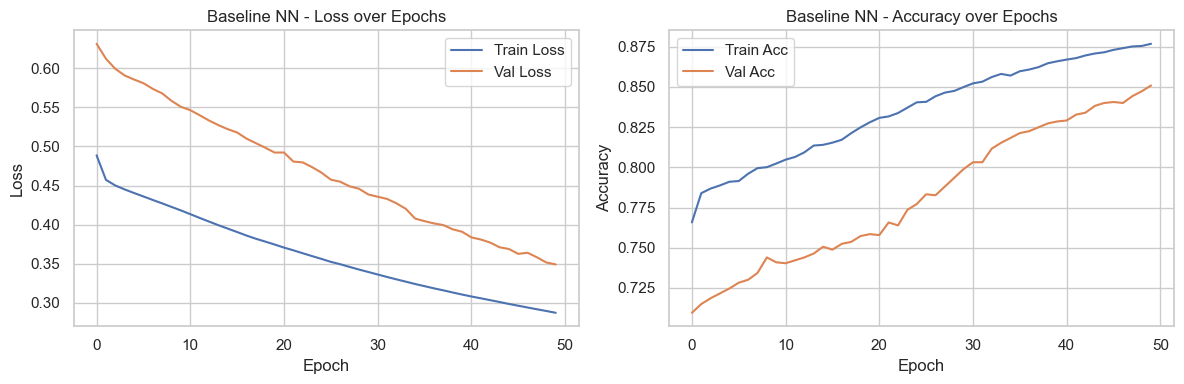

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

=== Neural Network (Baseline) ===
Accuracy : 0.7736
Precision: 0.5775
Recall   : 0.5481
F1-score : 0.5624
ROC AUC  : 0.8111

Classification report:
              precision    recall  f1-score   support

           0     0.8397    0.8551    0.8473      1035
           1     0.5775    0.5481    0.5624       374

    accuracy                         0.7736      1409
   macro avg     0.7086    0.7016    0.7049      1409
weighted avg     0.7701    0.7736    0.7717      1409



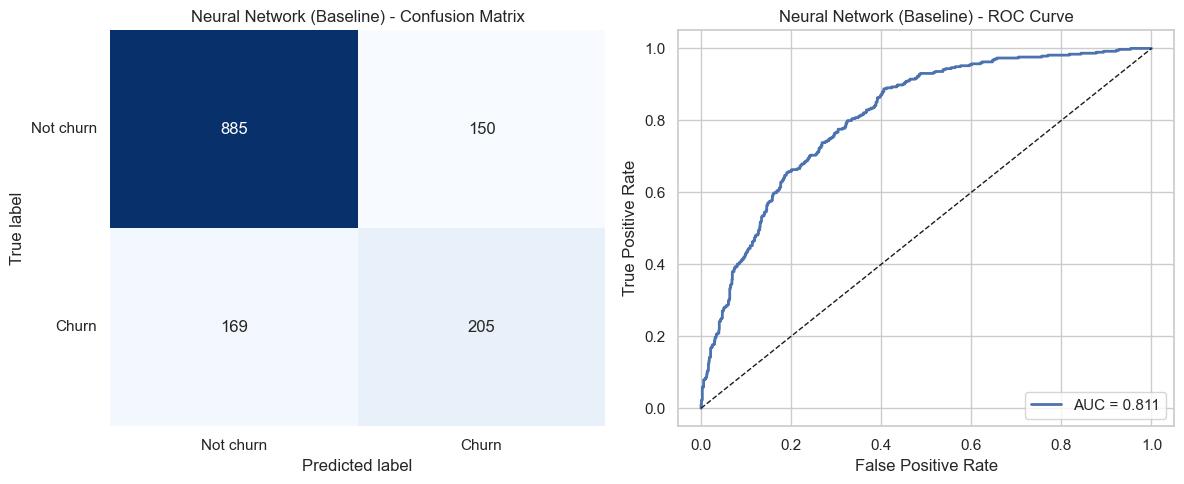

In [589]:
input_dim = X_train_sm.shape[1]

def build_baseline_nn(input_dim):
    model = Sequential([
        Dense(64, activation="relu", input_shape=(input_dim,)),
        Dense(32, activation="relu"),
        Dense(1, activation="sigmoid"),
    ])
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1,
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=1,
)

baseline_nn = build_baseline_nn(input_dim)

history_baseline = baseline_nn.fit(
    X_train_sm,
    y_train_sm,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1,
)

# Plot training history using subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# ----- Loss subplot -----
axes[0].plot(history_baseline.history["loss"], label="Train Loss")
axes[0].plot(history_baseline.history["val_loss"], label="Val Loss")
axes[0].set_title("Baseline NN - Loss over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)

# ----- Accuracy subplot -----
axes[1].plot(history_baseline.history["accuracy"], label="Train Acc")
axes[1].plot(history_baseline.history["val_accuracy"], label="Val Acc")
axes[1].set_title("Baseline NN - Accuracy over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


# Evaluate baseline NN on test set
y_proba_nn_base = baseline_nn.predict(X_test_proc).ravel()
y_pred_nn_base = (y_proba_nn_base >= 0.5).astype(int)

metrics_nn_base = evaluate_classifier(
    y_test,
    y_pred_nn_base,
    y_proba=y_proba_nn_base,
    model_name="Neural Network (Baseline)",
)

### TUNED NEURAL NETWORK (Keras)

Starting neural network hyperparameter search ...

Config 1/4: {'units1': 64, 'units2': 32, 'dropout': 0.2, 'lr': 0.001, 'batch_size': 64}

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.
Validation ROC AUC: 0.8552

Config 2/4: {'units1': 128, 'units2': 64, 'dropout': 0.3, 'lr': 0.001, 'batch_size': 64}

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.
Validation ROC AUC: 0.8604

Config 3/4: {'units1': 128, 'units2': 64, 'dropout': 0.4, 'lr': 0.0005, 'batch_size': 128}

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.
Validation ROC AUC: 0.8412

Config 4/4: {'units1': 256, 'units2': 128, 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 128}

Epoch 3: ReduceLROnPlate

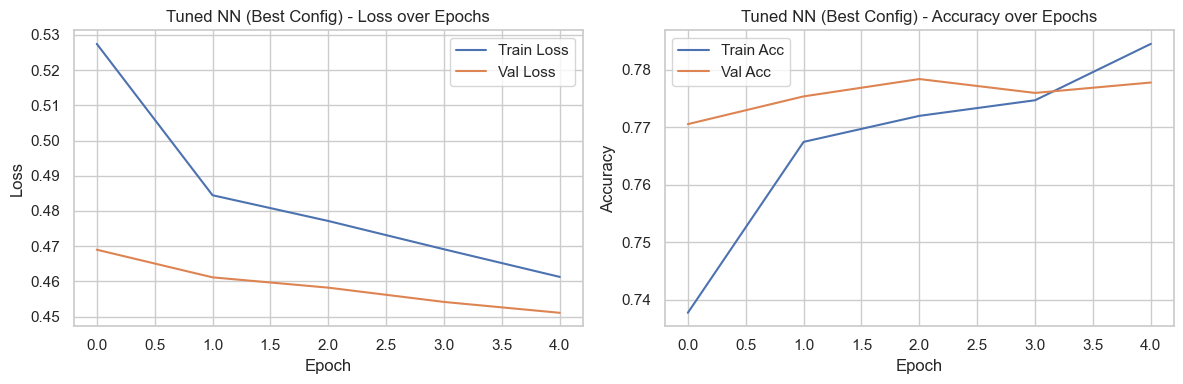

Epoch 1/60
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7573 - loss: 0.5014 - val_accuracy: 0.7192 - val_loss: 0.6189 - learning_rate: 0.0010
Epoch 2/60
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7656 - loss: 0.4739 - val_accuracy: 0.7277 - val_loss: 0.5976 - learning_rate: 0.0010
Epoch 3/60
 66/104 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - accuracy: 0.7722 - loss: 0.4746
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7762 - loss: 0.4651 - val_accuracy: 0.7337 - val_loss: 0.5685 - learning_rate: 0.0010
Epoch 4/60
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7815 - loss: 0.4551 - val_accuracy: 0.7391 - val_loss: 0.5642 - learning_rate: 5.0000e-04
Epoch 5/60
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7788 - loss: 0.4568 - val_accuracy: 0.7367 - val_loss: 0.5677 - learning_rate: 5.0000e-04
Epoch 5: early stopping
Restoring model weights from the end of the best epoch:

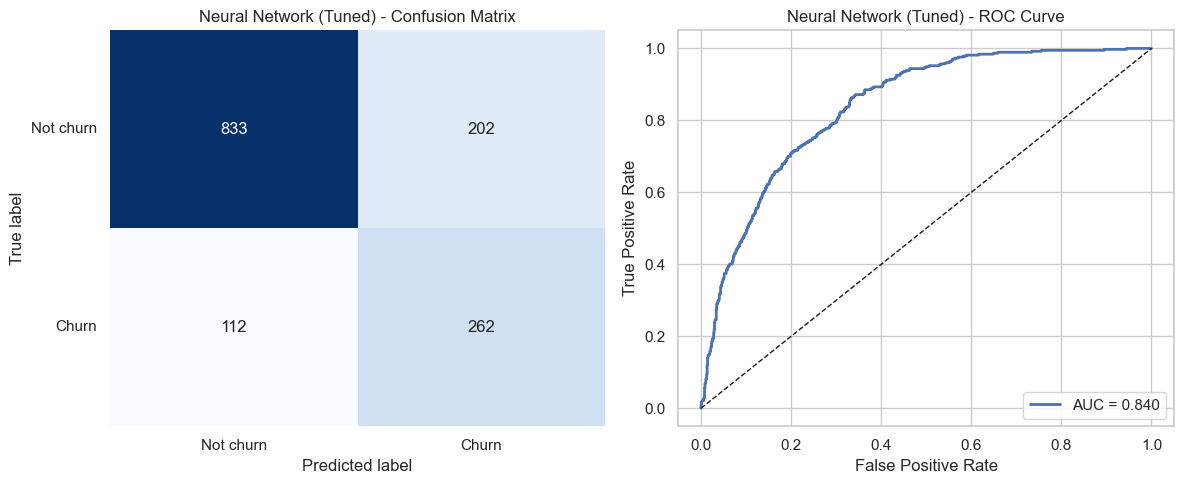

In [590]:
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(
    X_train_sm,
    y_train_sm,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_train_sm,
)

def build_nn_model(input_dim, units1=128, units2=64, dropout_rate=0.3, learning_rate=1e-3):
    model = Sequential([
        Dense(units1, activation="relu", input_shape=(input_dim,)),
        Dropout(dropout_rate),
        Dense(units2, activation="relu"),
        Dropout(dropout_rate),
        Dense(1, activation="sigmoid"),
    ])
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

param_grid_nn = [
    {"units1": 64,  "units2": 32,  "dropout": 0.2, "lr": 1e-3, "batch_size": 64},
    {"units1": 128, "units2": 64,  "dropout": 0.3, "lr": 1e-3, "batch_size": 64},
    {"units1": 128, "units2": 64,  "dropout": 0.4, "lr": 5e-4, "batch_size": 128},
    {"units1": 256, "units2": 128, "dropout": 0.3, "lr": 5e-4, "batch_size": 128},
]

best_auc = -np.inf
best_params_nn = None
best_history_nn = None
best_model_nn = None

print("Starting neural network hyperparameter search ...")

for i, params in enumerate(param_grid_nn, 1):
    print(f"\nConfig {i}/{len(param_grid_nn)}: {params}")

    model = build_nn_model(
        input_dim=input_dim,
        units1=params["units1"],
        units2=params["units2"],
        dropout_rate=params["dropout"],
        learning_rate=params["lr"],
    )

    history = model.fit(
        X_train_nn,
        y_train_nn,
        validation_data=(X_val_nn, y_val_nn),
        epochs=60,
        batch_size=params["batch_size"],
        callbacks=[early_stop, reduce_lr],
        verbose=0,
    )

    y_val_proba = model.predict(X_val_nn, verbose=0).ravel()
    val_auc = roc_auc_score(y_val_nn, y_val_proba)
    print(f"Validation ROC AUC: {val_auc:.4f}")

    if val_auc > best_auc:
        best_auc = val_auc
        best_params_nn = params
        best_history_nn = history
        best_model_nn = model

print("\nBest NN hyperparameters:", best_params_nn)
print(f"Best validation ROC AUC: {best_auc:.4f}")

# Plot best tuned NN history with subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# ----- Loss subplot -----
axes[0].plot(best_history_nn.history["loss"], label="Train Loss")
axes[0].plot(best_history_nn.history["val_loss"], label="Val Loss")
axes[0].set_title("Tuned NN (Best Config) - Loss over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)

# ----- Accuracy subplot -----
axes[1].plot(best_history_nn.history["accuracy"], label="Train Acc")
axes[1].plot(best_history_nn.history["val_accuracy"], label="Val Acc")
axes[1].set_title("Tuned NN (Best Config) - Accuracy over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


# Refit best NN on full SMOTE-balanced train set
nn_tuned = build_nn_model(
    input_dim=input_dim,
    units1=best_params_nn["units1"],
    units2=best_params_nn["units2"],
    dropout_rate=best_params_nn["dropout"],
    learning_rate=best_params_nn["lr"],
)

history_tuned_full = nn_tuned.fit(
    X_train_sm,
    y_train_sm,
    validation_split=0.2,
    epochs=60,
    batch_size=best_params_nn["batch_size"],
    callbacks=[early_stop, reduce_lr],
    verbose=1,
)

# Evaluate tuned NN on test set
y_proba_nn_tuned = nn_tuned.predict(X_test_proc).ravel()
y_pred_nn_tuned = (y_proba_nn_tuned >= 0.5).astype(int)

metrics_nn_tuned = evaluate_classifier(
    y_test,
    y_pred_nn_tuned,
    y_proba=y_proba_nn_tuned,
    model_name="Neural Network (Tuned)",
)

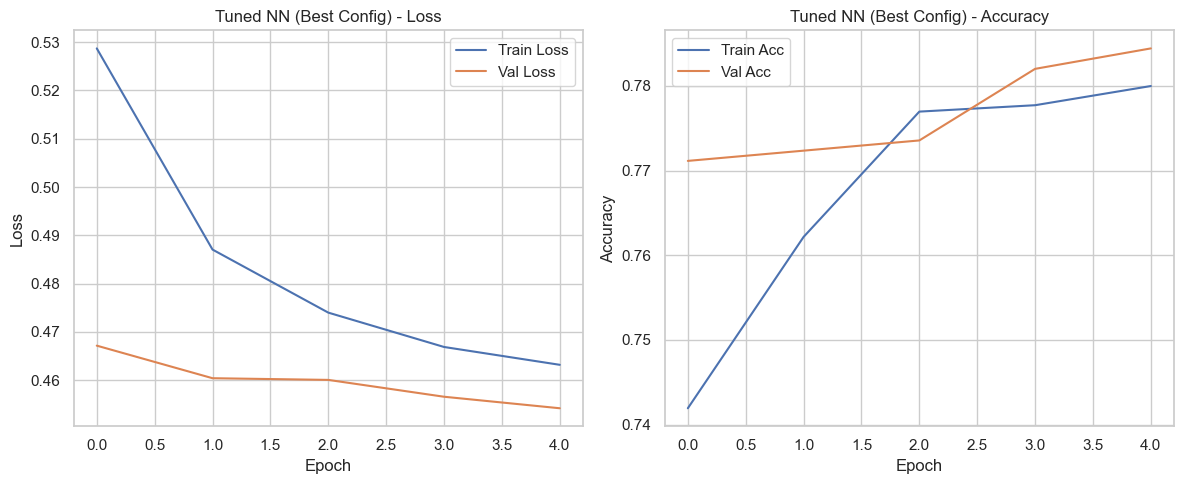

In [591]:
history = best_history.history  # for readability

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ---- Subplot 1: Loss ----
axes[0].plot(history["loss"], label="Train Loss")
axes[0].plot(history["val_loss"], label="Val Loss")
axes[0].set_title("Tuned NN (Best Config) - Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

# ---- Subplot 2: Accuracy ----
axes[1].plot(history["accuracy"], label="Train Acc")
axes[1].plot(history["val_accuracy"], label="Val Acc")
axes[1].set_title("Tuned NN (Best Config) - Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.tight_layout()
plt.show()


Epoch 1/60
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7332 - loss: 0.5257 - val_accuracy: 0.7271 - val_loss: 0.6195 - learning_rate: 0.0010
Epoch 2/60
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7776 - loss: 0.4711 - val_accuracy: 0.7186 - val_loss: 0.6177 - learning_rate: 0.0010
Epoch 3/60
 60/104 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.7707 - loss: 0.4783
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7757 - loss: 0.4675 - val_accuracy: 0.7258 - val_loss: 0.5896 - learning_rate: 0.0010
Epoch 4/60
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7845 - loss: 0.4576 - val_accuracy: 0.7355 - val_loss: 0.5709 - learning_rate: 5.0000e-04
Epoch 5/60
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7792 - loss: 0.4534 - val_accuracy: 0.7397 - val_loss: 0.5678 - learning_rate: 5.0000e-04
Epoch 5: early stopping
Restoring model weights from the end of the best epoch:

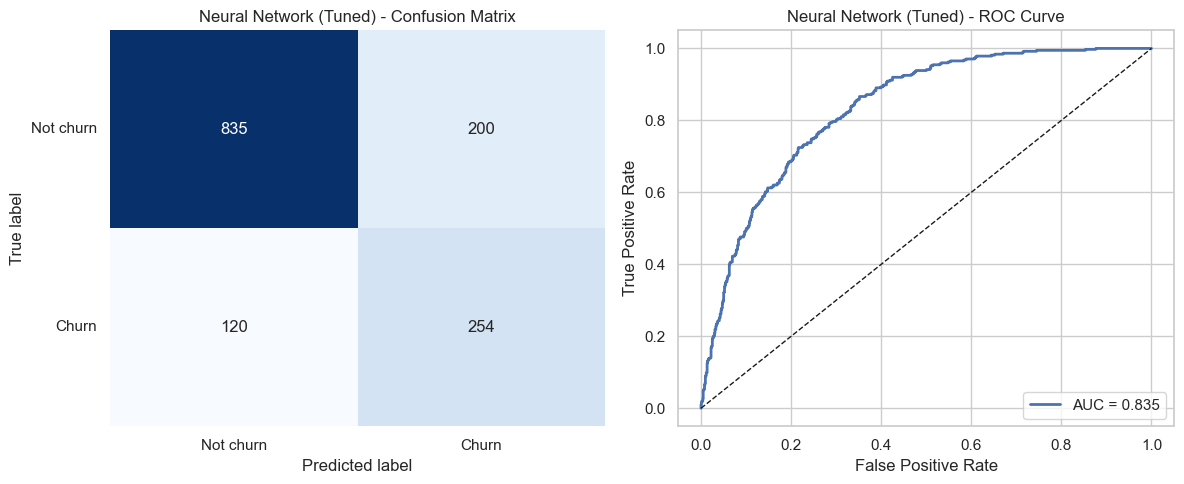

In [592]:
# Refit best architecture on full SMOTE-balanced training data
nn_tuned = build_nn_model(
    input_dim=input_dim,
    units1=best_params["units1"],
    units2=best_params["units2"],
    dropout_rate=best_params["dropout"],
    learning_rate=best_params["lr"],
)

history_tuned_full = nn_tuned.fit(
    X_train_sm,
    y_train_sm,
    validation_split=0.2,
    epochs=60,
    batch_size=best_params["batch_size"],
    callbacks=[early_stop, reduce_lr],
    verbose=1,
)

# Evaluate tuned NN on test set
y_proba_nn_tuned = nn_tuned.predict(X_test_proc).ravel()
y_pred_nn_tuned = (y_proba_nn_tuned >= 0.5).astype(int)

metrics_nn_tuned = evaluate_classifier(
    y_test,
    y_pred_nn_tuned,
    y_proba=y_proba_nn_tuned,
    model_name="Neural Network (Tuned)",
)


### MODEL EVALUATION & COMPARISON


=== Model Comparison Table ===
                       model  accuracy  precision    recall        f1  \
0   Decision Tree (Baseline)  0.723208   0.481735  0.564171  0.519704   
1      Decision Tree (Tuned)  0.745919   0.515564  0.708556  0.596847   
2  Neural Network (Baseline)  0.773598   0.577465  0.548128  0.562414   
3     Neural Network (Tuned)  0.772889   0.559471  0.679144  0.613527   

    roc_auc  
0  0.672213  
1  0.815421  
2  0.811067  
3  0.834951  


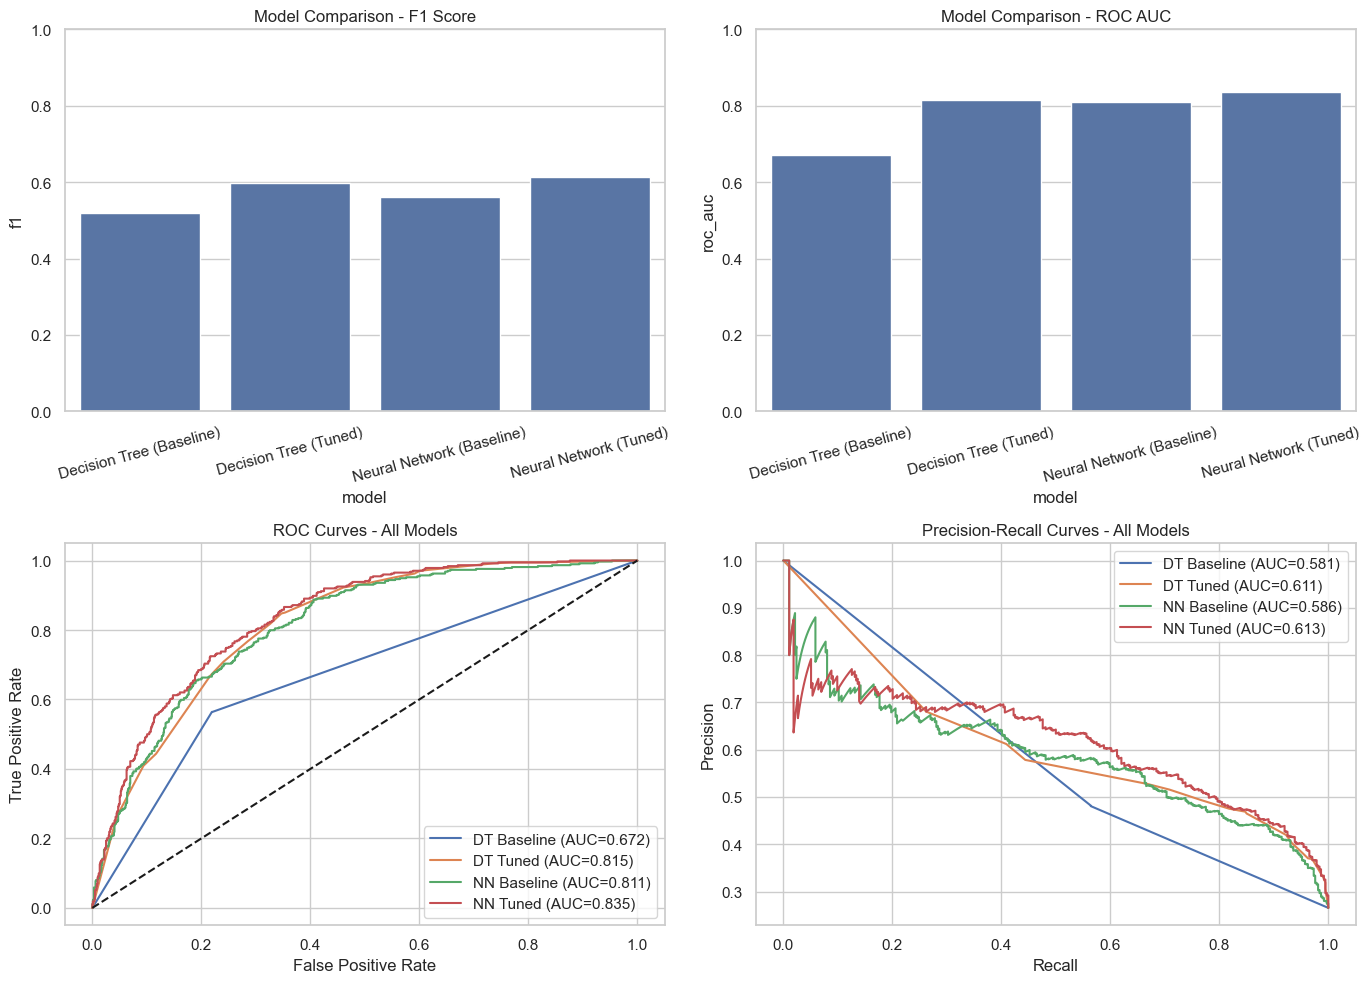

In [593]:
# Build rows that include a 'model' name + all metrics
comparison_rows = [
    {"model": "Decision Tree (Baseline)",  **metrics_dt_base},
    {"model": "Decision Tree (Tuned)",     **metrics_dt_tuned},
    {"model": "Neural Network (Baseline)", **metrics_nn_base},
    {"model": "Neural Network (Tuned)",    **metrics_nn_tuned},
]

results = pd.DataFrame(comparison_rows)

print("\n=== Model Comparison Table ===")
print(results)

# Prepare probabilities dict
y_proba_all = {
    "DT Baseline":      y_proba_dt_base,
    "DT Tuned":         y_proba_dt_tuned,
    "NN Baseline":      y_proba_nn_base,
    "NN Tuned":         y_proba_nn_tuned,
}

# ---------- 4 SUBPLOTS ----------
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ---- Subplot 1: F1 Barplot ----
sns.barplot(x="model", y="f1", data=results, ax=axes[0,0])
axes[0,0].set_title("Model Comparison - F1 Score")
axes[0,0].set_xticklabels(results["model"], rotation=15)
axes[0,0].set_ylim(0,1)

# ---- Subplot 2: ROC-AUC Barplot ----
sns.barplot(x="model", y="roc_auc", data=results, ax=axes[0,1])
axes[0,1].set_title("Model Comparison - ROC AUC")
axes[0,1].set_xticklabels(results["model"], rotation=15)
axes[0,1].set_ylim(0,1)

# ---- Subplot 3: Combined ROC Curves ----
for lbl, y_prob in y_proba_all.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = auc(fpr, tpr)
    axes[1,0].plot(fpr, tpr, label=f"{lbl} (AUC={auc_score:.3f})")

axes[1,0].plot([0,1], [0,1], 'k--')
axes[1,0].set_title("ROC Curves - All Models")
axes[1,0].set_xlabel("False Positive Rate")
axes[1,0].set_ylabel("True Positive Rate")
axes[1,0].legend()

# ---- Subplot 4: Combined PR Curves ----
for lbl, y_prob in y_proba_all.items():
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)
    axes[1,1].plot(recall, precision, label=f"{lbl} (AUC={pr_auc:.3f})")

axes[1,1].set_title("Precision-Recall Curves - All Models")
axes[1,1].set_xlabel("Recall")
axes[1,1].set_ylabel("Precision")
axes[1,1].legend()

plt.tight_layout()
plt.show()


In [594]:
comparison_rows = [
    {"model": "Decision Tree (Baseline)",      **metrics_dt_base},
    {"model": "Decision Tree (Tuned)",         **metrics_dt_tuned},
    {"model": "Neural Network (Baseline)",     **metrics_nn_base},
    {"model": "Neural Network (Tuned)",        **metrics_nn_tuned},
]

comparison_df = pd.DataFrame(comparison_rows)
print("\n=== Model Comparison Table ===")
display(comparison_df)



=== Model Comparison Table ===


,model,accuracy,precision,recall,f1,roc_auc
0,Decision Tree (Baseline),0.723208,0.481735,0.564171,0.519704,0.672213
1,Decision Tree (Tuned),0.745919,0.515564,0.708556,0.596847,0.815421
2,Neural Network (Baseline),0.773598,0.577465,0.548128,0.562414,0.811067
3,Neural Network (Tuned),0.772889,0.559471,0.679144,0.613527,0.834951
